## GPU Test

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=f605c8d9b7f354bdcb47c69fa538ca102558a388f1d1e130c0aa29c767225e03
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  |     Proc size: 111.8 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total     15109MB


# Google Mount

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Constant

In [ ]:
import pandas as pd
import os

DATA_DIR = '/content/gdrive/My Drive/Kaggle/Cassava/'
TRAIN_DIR = DATA_DIR + 'train/'#_images/'
TEST_DIR = DATA_DIR + 'test_images/'
BATCH_SIZE = 4
NUM_CLASSES = 5
SEED = 0
EPOCH = 6
INPUT_SIZE = 512

# 학교 컴퓨터 이용할 수 있도록 논의해볼 것

# Data Check

In [ ]:
os.listdir(DATA_DIR)

['sample_submission.csv',
 'train.csv',
 'label_num_to_disease_map.json',
 'merged.csv',
 'train_images',
 'test_images',
 'model1_866.h5',
 'train',
 'sectry_12e_4815.h5']

In [ ]:
import json

with open('/content/gdrive/My Drive/Kaggle/Cassava/label_num_to_disease_map.json', 'r') as file:
    labels = json.load(file)
    
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [ ]:
label = pd.read_csv(DATA_DIR + 'merged.csv')
label.label = label.label.astype("str")

In [ ]:
label.head()

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


In [ ]:
print(label.label.value_counts())
"""
train_img = os.listdir(TRAIN_DIR)
test_img = os.listdir(TEST_DIR)

print('Number of train_img', len(train_img))
print('Number of test_img' ,len(test_img))
"""

3    15462
1     3476
2     3017
4     2890
0     1492
Name: label, dtype: int64


"\ntrain_img = os.listdir(TRAIN_DIR)\ntest_img = os.listdir(TEST_DIR)\n\nprint('Number of train_img', len(train_img))\nprint('Number of test_img' ,len(test_img))\n"

# Image Check

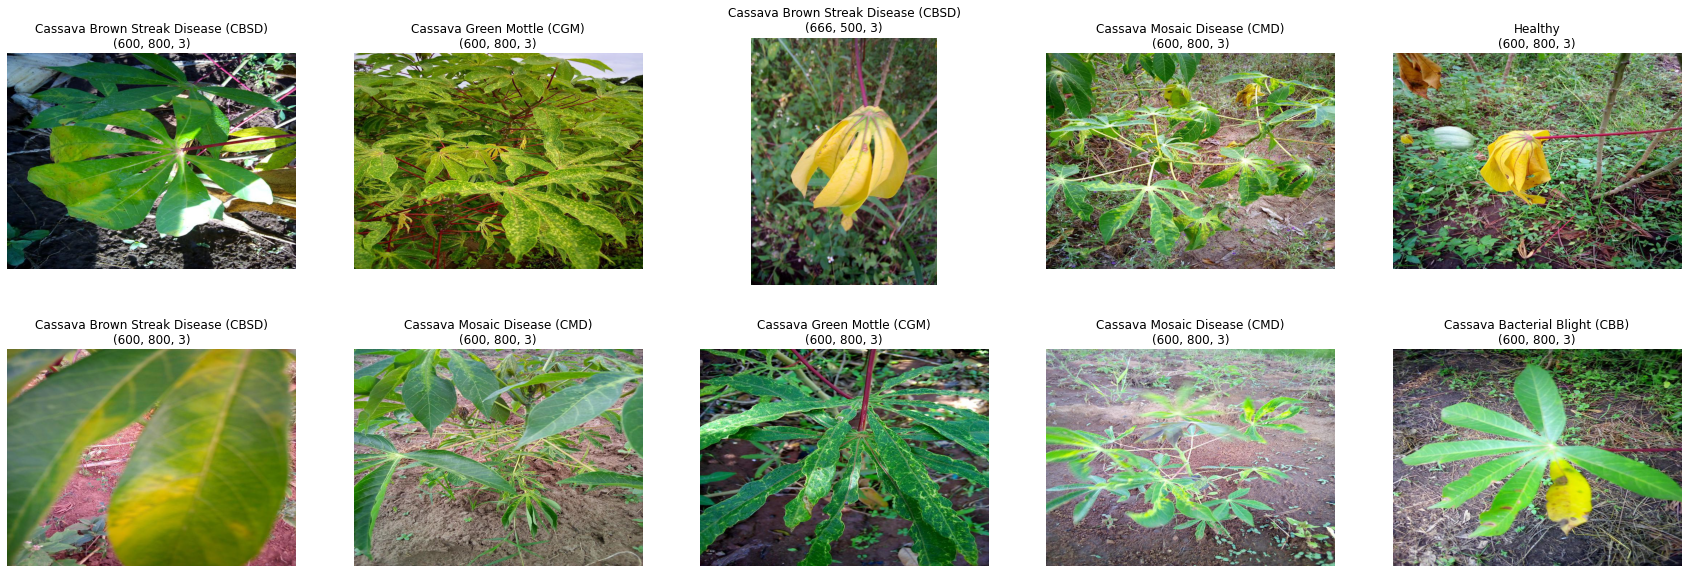

In [ ]:
label['path'] = TRAIN_DIR + label.image_id

import matplotlib.pyplot as plt
import numpy as np

fig,axes = plt.subplots(2,5,figsize = (30,10))

for ax in axes.reshape(-1,):
    rnd_idx = np.random.randint(label.index[0],label.index[-1])
    arr = plt.imread(TRAIN_DIR + label.loc[rnd_idx,'image_id'])
    ax.imshow(arr)
    ax.set_title(str(labels.get(label.loc[rnd_idx, 'label'])) + '\n' + str(arr.shape))
    ax.axis('off')

# Image Average Size Check

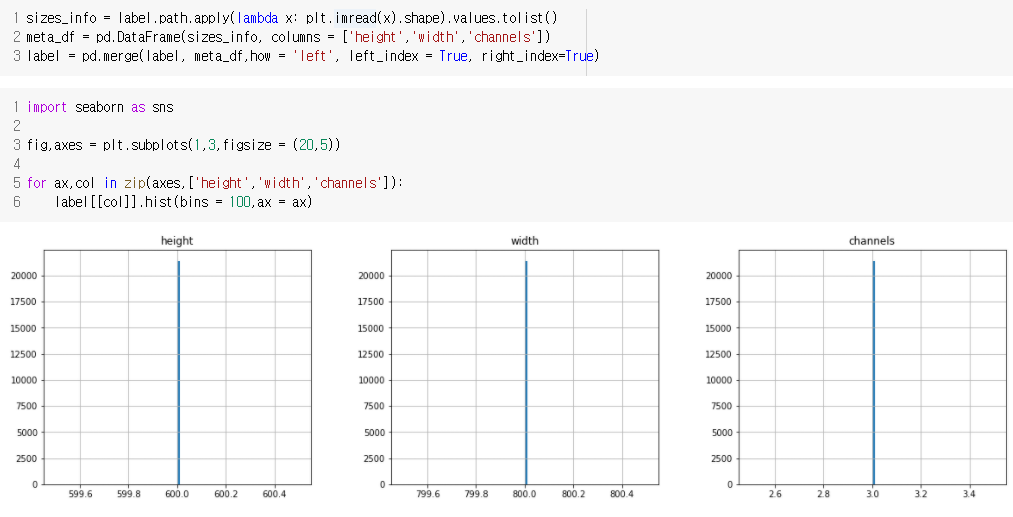

In [ ]:
"""
sizes_info = label.path.apply(lambda x: plt.imread(x).shape).values.tolist()
meta_df = pd.DataFrame(sizes_info, columns = ['height','width','channels'])
label = pd.merge(label, meta_df,how = 'left', left_index = True, right_index=True)

import seaborn as sns

fig,axes = plt.subplots(1,3,figsize = (20,5))

for ax,col in zip(axes,['height','width','channels']):
    label[[col]].hist(bins = 100,ax = ax)
"""

"\nsizes_info = label.path.apply(lambda x: plt.imread(x).shape).values.tolist()\nmeta_df = pd.DataFrame(sizes_info, columns = ['height','width','channels'])\nlabel = pd.merge(label, meta_df,how = 'left', left_index = True, right_index=True)\n\nimport seaborn as sns\n\nfig,axes = plt.subplots(1,3,figsize = (20,5))\n\nfor ax,col in zip(axes,['height','width','channels']):\n    label[[col]].hist(bins = 100,ax = ax)\n"

# Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.3,
    zoom_range = 0.3,
    fill_mode = 'nearest',
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe = label,
    directory = TRAIN_DIR,
    x_col = "image_id" ,
    y_col = "label",
    color_mode = 'rgb',
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = False,
    class_mode = "categorical",
    target_size = (INPUT_SIZE, INPUT_SIZE)
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = label,
    directory = TRAIN_DIR,
    x_col = "image_id",
    y_col = "label",
    color_mode = 'rgb',
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = False,
    class_mode = "categorical",
    target_size = (INPUT_SIZE, INPUT_SIZE)
)

# 데이터 셋 자체를 줄여서 Overfitting을 만들고 거기서부터 늘려가기.

Found 21070 validated image filenames belonging to 5 classes.
Found 5267 validated image filenames belonging to 5 classes.


# Create Model

In [ ]:
from keras.applications import ResNet50, VGG16, InceptionV3, InceptionResNetV2, Xception
from tensorflow.keras.applications import EfficientNetB0
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD

from tensorflow.keras import layers
"""
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.9),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0.2)),
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomContrast(0.1),
        layers.experimental.preprocessing.CenterCrop(INPUT_SIZE, INPUT_SIZE),
    ]
)
"""
def create_model(MODEL, learning_rate = 1e-5) :

  model = Sequential()

  base = MODEL(include_top = False, weights = "imagenet", input_shape = (INPUT_SIZE, INPUT_SIZE, 3))

  # 레이어 Freeze

  base.trainbale = True
  """
  for layer in base.layers:
      layer.trainable = True
  """

  model = Sequential([
      #Input(shape = (INPUT_SIZE, INPUT_SIZE, 3)),
      #data_augmentation_layers,
      base,
      GlobalAveragePooling2D(),
      Dense(256, activation ='relu'),
      Dropout(0.3),
      Dense(NUM_CLASSES, activation = 'softmax')
  ])
# Multi-Layer Perceptron이 H 레이어가 3개부터 학습이 잘 되지 않는다는 통계가 있음

  # 모델 컴파일

  model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 1e-5),
              metrics   = ['accuracy'])

  return model

In [ ]:
#model = create_model(EfficientNetB0)
model = tf.keras.models.load_model(DATA_DIR + 'sectry_12e_4815.h5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 16, 16, 1280)      4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 4,378,792
Trainable params: 4,336,769
Non-trainable params: 42,023
_________________________________________________________________


# Callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_check = ModelCheckpoint(
    "./sectry.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = "min"
)

early_stop= EarlyStopping(
    monitor = "val_loss",
    min_delta = 0.001,
    patience = 5,
    verbose = 1,
    mode = "min",
    #baseline=None,
    restore_best_weights = False
)

In [ ]:
hist = model.fit_generator(generator = train_generator,
                           epochs = EPOCH,
                           steps_per_epoch = train_generator.n // train_generator.batch_size,
                           validation_data = val_generator,
                           validation_steps = val_generator.n // val_generator.batch_size,
                           callbacks = [model_check, early_stop]
                           )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
5267/5267 [==============================] - 11437s 2s/step - loss: 0.4166 - accuracy: 0.8628 - val_loss: 0.4905 - val_accuracy: 0.8566

Epoch 00001: val_loss improved from inf to 0.49049, saving model to ./sectry.h5
Epoch 2/6
5267/5267 [==============================] - 1860s 353ms/step - loss: 0.4066 - accuracy: 0.8663 - val_loss: 0.5480 - val_accuracy: 0.8374

Epoch 00002: val_loss did not improve from 0.49049
Epoch 3/6
5267/5267 [==============================] - 1772s 336ms/step - loss: 0.4070 - accuracy: 0.8638 - val_loss: 0.5336 - val_accuracy: 0.8418

Epoch 00003: val_loss did not improve from 0.49049
Epoch 4/6
5267/5267 [==============================] - 1783s 339ms/step - loss: 0.3950 - accuracy: 0.8677 - val_loss: 0.5357 - val_accuracy: 0.8435

Epoch 00004: val_loss did not improve from 0.49049
Epoch 5/6
5267/5267 [==============================] - 1778s 338ms/step - loss: 0.3890 - accuracy: 0.8715 - val_loss: 0.4729 - val_accuracy: 0.8604

Epoch 00005: val_loss im

Result

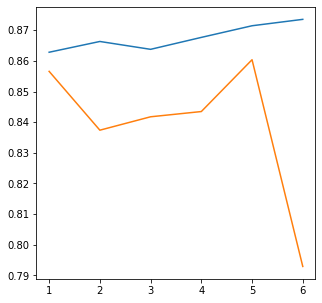

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(range(1, len(hist.history['accuracy']) + 1), hist.history['accuracy'])
ax.plot(range(1, len(hist.history['val_accuracy']) + 1), hist.history['val_accuracy'])

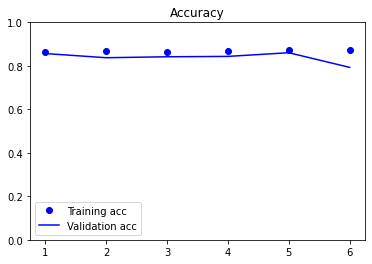

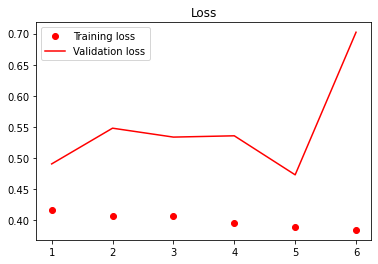

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
subm = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
subm.head()

,image_id,label
0,2216849948.jpg,4


In [ ]:
label2 = subm.copy()
label2['path'] = TEST_DIR + '/data' + label2.image_id 

label2.head()

,image_id,label,path
0,2216849948.jpg,4,/content/gdrive/My Drive/Kaggle/Cassava/test_i...


In [ ]:
"""fig,axes = plt.subplots(1,1,figsize = (5, 5))

arr = plt.imread(label2.loc[0,'path'])
ax.imshow(arr)
#ax.set_title(label.loc[rnd_idx,'breed']+'\n'+str(arr.shape))
ax.axis('off')"""

"fig,axes = plt.subplots(1,1,figsize = (5, 5))\n\narr = plt.imread(label2.loc[0,'path'])\nax.imshow(arr)\n#ax.set_title(label.loc[rnd_idx,'breed']+'\n'+str(arr.shape))\nax.axis('off')"

In [ ]:
"""test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (300, 300),
        color_mode = "rgb",
        shuffle = False,
        class_mode = 'categorical',
        batch_size = 1)

filenames = test_generator.filenames
nb_samples = len(filenames)
"""

'test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)\n\ntest_generator = test_datagen.flow_from_directory(\n        TEST_DIR,\n        target_size = (300, 300),\n        color_mode = "rgb",\n        shuffle = False,\n        class_mode = \'categorical\',\n        batch_size = 1)\n\nfilenames = test_generator.filenames\nnb_samples = len(filenames)\n'

In [ ]:
"""predict = model.predict_generator(test_generator, steps = nb_samples)"""

'predict = model.predict_generator(test_generator, steps = nb_samples)'

In [ ]:
"""predict"""

'predict'

In [ ]:
model.save('6epo.h5')